In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Flatten
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model, multi_gpu_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, CapsCNN, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.mnist import dataGenerator

Using TensorFlow backend.


In [2]:
# Plotting for dark theme
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Parameters

In [3]:
num_class = 10
input_shape = (28, 28, 1)
m_train = 60000
m_test = 10000

batch_size = 16

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

test_augmentation = {
    'width_shift_range': 10,
    'height_shift_range': 10
}

# Dataset

In [4]:
trainGenerator = dataGenerator('train', batch_size=batch_size, reshape=False, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False)

# Model

In [5]:
model = Sequential([    
    Convolution2D(filters=128, kernel_size=(9, 9), padding='valid', activation='relu', input_shape=input_shape),
    Convolution2D(filters=12, kernel_size=(9, 9), padding='valid', activation='relu'),
    
    CapsCNN(16, kernel_size=(5, 5), routings=3, activation_caps=squash),
    
    ClassesCaps(),
    Flatten(),
    Dense(10, name='capsule')
])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 128)       10496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 12)        124428    
_________________________________________________________________
caps_cnn_1 (CapsCNN)         (None, 8, 8, 16)          4800      
_________________________________________________________________
classes_caps_1 (ClassesCaps) (None, 8, 8)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
capsule (Dense)              (None, 10)                650       
Total params: 140,374
Trainable params: 140,374
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
model.compile(optimizer=Adam(lr=3e-4),
              loss=margin(),
              metrics={'capsule': 'categorical_accuracy'})

In [8]:
hist = model.fit_generator(trainGenerator,
                           steps_per_epoch=trainGenerator.n // trainGenerator.batch_size,
                           epochs=5,
                           validation_data=testGenerator,
                           validation_steps=testGenerator.n // testGenerator.batch_size,
                           workers=4,
                           verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
3750/3750 [==============================] - 63s 17ms/step - loss: 0.2041 - categorical_accuracy: 0.7833 - val_loss: 0.0708 - val_categorical_accuracy: 0.9446
Epoch 2/5
3750/3750 [==============================] - 61s 16ms/step - loss: 0.0837 - categorical_accuracy: 0.9254 - val_loss: 0.0436 - val_categorical_accuracy: 0.9643
Epoch 3/5
3750/3750 [==============================] - 61s 16ms/step - loss: 0.0575 - categorical_accuracy: 0.9491 - val_loss: 0.0310 - val_categorical_accuracy: 0.9744
Epoch 4/5
3750/3750 [==============================] - 60s 16ms/step - loss: 0.0457 - categorical_accuracy: 0.9596 - val_loss: 0.0259 - val_categorical_accuracy: 0.9769
Epoch 5/5
3750/3750 [==============================] - 60s 16ms/step - loss: 0.0379 - categorical_accuracy: 0.9661 - val_loss: 0.0232 - val_categorical_accuracy: 0.9804


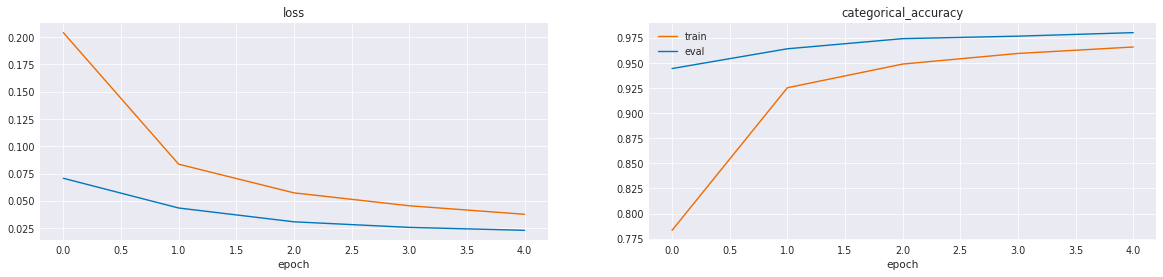

In [9]:
plotHistory(hist.history)
plt.savefig('mnist_CNN.png')